In [104]:
from __future__ import print_function

import time
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift

class LayerKmeans(object):

    def __init__(self, kernel_size=2, n_clusters=5):
        self.ks = kernel_size
        self.nc = n_clusters
        self.ready = False
    
    def train(self, images):

        def cluster(images):
            patches = _gather_patches(images, self.ks)
            kmeans = KMeans(n_clusters=self.nc)
            kmeans.fit(patches)
            return kmeans, patches

        time_start = time.clock()
        kmeans_L1, patches_L1 = cluster(images)
        print('kmeans on L1 clustering cost: %.3f sec' % 
                (time.clock() - time_start, ))

        images_ds = _downsample(images, self.ks)
        print('down sample shape: ' + str(images_ds.shape))

        time_start = time.clock()
        kmeans_L2, patches_L2 = cluster(images_ds)
        print('kmeans on L2 clustering cost: %.3f sec' % 
                (time.clock() - time_start, ))
        
        self.kmeans = [kmeans_L1, kmeans_L2]
        
        return

        label_L2 = np.expand_dims(kmeans_L2.labels_, axis=1)
        label_L2 = np.tile(label_L2, [1,ks*ks])
        label_L2 = np.reshape(label_L2, [-1])

        Saak = [[None] * self.nc for i in range(self.nc)]

        for i in range(self.nc):
            for j in range(self.nc):
                ind = np.logical_and(kmeans_L1.labels_ == i,
                        label_L2 == j)
                patches = patches_L1[ind,:]
                Saak[i][j] = SaakStage(patches, self.ks)

        print('kmeans done!')

    def test_patches(self, patches, layer):
        # assert self.ready
        assert layer == 1 or layer == 2
        return self.kmeans[layer - 1].predict(patches)

    def test_images(self, images):
        # get images shape
        n, h, w, ch = images.shape
        ks = self.ks
        nc = self.nc

        # get downsampled images
        images_ds = _downsample(images, ks)
        # n_ds, h_ds, w_ds, ch_ds = images_ds.shape
        
        # get L2
        patches_L2 = _gather_patches(images_ds, ks)
        # indices_L2 = np.arange(len(patches_L2))
        label_L2 = self.test_patches(patches_L2, layer=2)
        label_L2_up = np.expand_dims(label_L2, axis=1)
        label_L2_up = np.tile(label_L2, [1, ks*ks])
        # np.save('p1_3.npy', label_L2_up)
        label_L2_up = np.reshape(label_L2_up, [-1])
        # label_L2_reshaped = _reshape_patches(label_L2, h, w, ch)
        print('label L2 shape: ' + str(label_L2.shape))
        print('label L2 up shape: ' + str(label_L2_up.shape))

        # get L1
        patches_L1 = _gather_patches(images, ks)
        # indices_L1 = np.arange(len(patches_L1))
        label_L1 = self.test_patches(patches_L1, layer=1)
        print('label L1 shape: ' + str(label_L1.shape))


        # np.save('p2.npy', label_L1)

        # np.save('p1.npy', label_L2_up)
        # np.save('p1_2.npy', label_L2)

        result = patches
        for i in range(nc):
            for j in range(nc):
                ind = np.logical_and(label_L1 == i, label_L2_up == j)
                patches = patches_L1[ind,:]
                print('L1 = %d L2 = %d: %d' 
                        % (i, j, len(patches)))
                # indices = indices_L1[ind]

class LayerMeanShift(object):
    
    def __init__(self, kernel_size=2):
        self.ks = kernel_size
    
    def train(self, images):
        n, h, w, ch = images.shape
        ks = self.ks
        
        def cluster(images):
            patches = _gather_patches(images, ks)
            ms = MeanShift(bin_seeding=True, cluster_all=False, n_jobs=4)
            ms.fit(patches)
            return ms, patches

        time_start = time.clock()
        ms_L1, patches_L1 = cluster(images)
        print('mean shift on L1 clustering cost: %.3f sec' % 
                (time.clock() - time_start, ))

        images_ds = _downsample(images, self.ks)
        print('down sample shape: ' + str(images_ds.shape))

        time_start = time.clock()
        ms_L2, patches_L2 = cluster(images_ds)
        print('mean shift on L2 clustering cost: %.3f sec' % 
                (time.clock() - time_start, ))
        
        self.ms = [ms_L1, ms_L2]
        self.patches = [patches_L1, patches_L2]
        
        return
        

def _gather_patches(images, ks):
    n, h, w, ch = images.shape
    p = np.array(
            [np.reshape(images[:,i:i+ks,j:j+ks,:],[-1,ks*ks*ch])
                for i in range(0, h, ks)
                for j in range(0, w, ks)
                ]
            )
    print('patch shape: ' + str(p.shape))

    p = p.transpose([1,0,2])
    print('patch shape: ' + str(p.shape))

    p = np.reshape(p, [-1,ks*ks*ch])
    print('patch shape: ' + str(p.shape))

    return p


def _reshape_patches(patches, h, w, ch):
    images = np.reshape(patches, [-1, h, w, ch])
    return images

def _downsample(images, scale):
    n, h, w, ch = images.shape
    patches = _gather_patches(images, ks=scale)
    k = len(patches)
    patches = np.reshape(patches, [k, -1, ch])
    patches = np.mean(patches, axis=1)
    images_ds = _reshape_patches(patches, h / scale, w / scale, ch)
    return images_ds


a = '''
if __name__ == '__main__':
    lk = LayerKmeans()

    images = np.load('../images_voc12_train_32x32_lab.npy')
    images = images / 255.
    L = np.expand_dims(images[:,:,:,0], axis=3)
    A = np.expand_dims(images[:,:,:,1], axis=3)
    B = np.expand_dims(images[:,:,:,2], axis=3)

    # lk.train(L)
    # lk.test_images(L)
'''

In [105]:
images = np.load('../images_voc12_train_32x32_lab.npy')
images = images / 255.

L = np.expand_dims(images[:,:,:,0], axis=3)
A = np.expand_dims(images[:,:,:,1], axis=3)
B = np.expand_dims(images[:,:,:,2], axis=3)

In [10]:
images[0,:,:,0]

array([[ 0.76862745,  0.79215686,  0.81960784, ...,  0.92941176,
         0.91764706,  0.90196078],
       [ 0.78039216,  0.80784314,  0.83137255, ...,  0.93333333,
         0.92156863,  0.90980392],
       [ 0.78823529,  0.81176471,  0.83529412, ...,  0.94117647,
         0.9254902 ,  0.91372549],
       ..., 
       [ 0.38039216,  0.16470588,  0.20784314, ...,  0.25882353,
         0.3372549 ,  0.45490196],
       [ 0.11372549,  0.10588235,  0.2       , ...,  0.21568627,
         0.20784314,  0.20392157],
       [ 0.04313725,  0.05490196,  0.07058824, ...,  0.19607843,
         0.17254902,  0.14117647]])

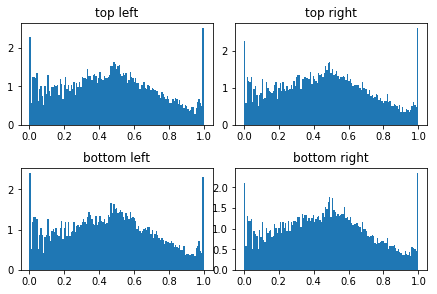

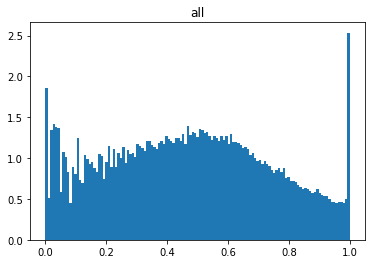

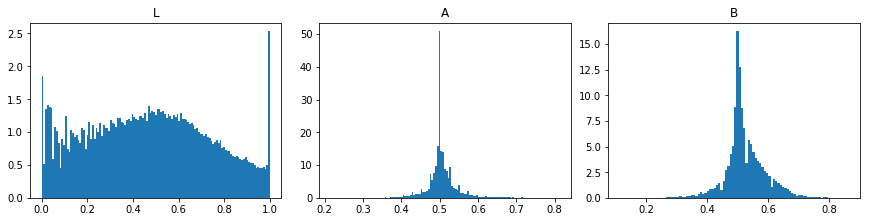

In [119]:
plt.close('all')
plt.figure(1)
plt.subplot(221)
plt.hist(np.reshape(msl.patches[0][:,0], [-1]), bins=127, normed=True)
plt.title('top left')

plt.subplot(222)
plt.hist(np.reshape(msl.patches[0][:,1], [-1]), bins=127, normed=True)
plt.title('top right')

plt.subplot(223)
plt.hist(np.reshape(msl.patches[0][:,2], [-1]), bins=127, normed=True)
plt.title('bottom left')

plt.subplot(224)
plt.hist(np.reshape(msl.patches[0][:,3], [-1]), bins=127, normed=True)
plt.title('bottom right')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()

plt.figure(2)
plt.hist(np.reshape(L, [-1]), bins=127, normed=True)
plt.title('all')
plt.show()

plt.figure(3, figsize=(12,3))
plt.subplot(131)
plt.hist(np.reshape(L, [-1]), bins=127, normed=True)
plt.title('L')

plt.subplot(132)
plt.hist(np.reshape(A, [-1]), bins=127, normed=True)
plt.title('A')

plt.subplot(133)
plt.hist(np.reshape(B, [-1]), bins=100, normed=True)
plt.title('B')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()

In [49]:
import matplotlib as m
m.__version__

'2.0.2'

In [106]:
msl = LayerMeanShift()
msl.train(L[:100,:,:,:])

patch shape: (256, 100, 4)
patch shape: (100, 256, 4)
patch shape: (25600, 4)
mean shift on L1 clustering cost: 44.164 sec
patch shape: (256, 100, 4)
patch shape: (100, 256, 4)
patch shape: (25600, 4)
down sample shape: (100, 16, 16, 1)
patch shape: (64, 100, 4)
patch shape: (100, 64, 4)
patch shape: (6400, 4)
mean shift on L2 clustering cost: 4.194 sec


In [103]:
print(msl.ms[0].cluster_centers_)
print(msl.ms[1].cluster_centers_)

[[ 0.47631376  0.4776519   0.47523741  0.47549796]]
[[ 0.46261822  0.46226177  0.46067326  0.46207996]]
